<a href="https://colab.research.google.com/github/Anson422/Anson-Eva-Valerie/blob/main/Text%20Analysis/Code_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/Anson422/Anson-Eva-Valerie.git #clone the repository to the local machine

fatal: destination path 'Anson-Eva-Valerie' already exists and is not an empty directory.


In [7]:
!apt-get update
!apt-get install -y poppler-utils tesseract-ocr
!pip install PyPDF2 pycryptodome pymupdf pdfplumber pdf2image pytesseract --upgrade


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [11]:
#Checking if the cloning was successfull
# Navigate to the cloned repository folder
repository_path = '/content/Anson-Eva-Valerie'

if os.path.exists(repository_path):
    print("Repository cloned successfully!")
    print("Files in the repository:", os.listdir(repository_path))
else:
    print("Repository cloning failed.")

Repository cloned successfully!
Files in the repository: ['Text Analysis', 'hello.ipynb', '.git', 'Stacked Bar Chart', 'Choropleth Map Analysis', 'README.md']


In [10]:
#install the necessary libraries
import os
import PyPDF2
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from PyPDF2 import PdfReader
import fitz  # PyMuPDF
import warnings
from collections import defaultdict
import pytesseract
import warnings
import pdfplumber
from pdf2image import convert_from_path
import sys
import logging


In [12]:
# Suppress all warnings globally (if needed)
warnings.simplefilter("ignore")

In [13]:
#suppress only PyPDF2 warnings
logging.getLogger("PyPDF2").setLevel(logging.ERROR)  # Suppress PyPDF2 warnings globally

# Function to extract text using PyPDF2
def extract_text_with_pypdf2(pdf_path):
    text = ""
    try:
        reader = PdfReader(pdf_path)
        for page in reader.pages:
            text += page.extract_text() or ""
    except Exception as e:
        print(f"PyPDF2 failed for {pdf_path}: {e}")
    return text

# Function to extract text using pdfplumber
def extract_text_with_pdfplumber(pdf_path):
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() or ""
    except Exception as e:
        print(f"pdfplumber failed for {pdf_path}: {e}")
    return text

# Function to extract text using OCR
def extract_text_with_ocr(pdf_path):
    text = ""
    try:
        images = convert_from_path(pdf_path)
        for image in images:
            text += pytesseract.image_to_string(image)
    except Exception as e:
        print(f"OCR failed for {pdf_path}: {e}")
    return text

# Unified function to extract text
def extract_text_from_pdf(pdf_path):
    # Try PyPDF2
    text = extract_text_with_pypdf2(pdf_path)
    if not text.strip():  # Fallback to pdfplumber if PyPDF2 fails
        text = extract_text_with_pdfplumber(pdf_path)
    if not text.strip():  # Fallback to OCR if pdfplumber also fails
        text = extract_text_with_ocr(pdf_path)
    return text

In [25]:
# Define the folder containing the EU energy publications in 2024
EU_Energy_publications_2024 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2024'

In [14]:
# List of keyword categories and their synonyms
keyword_groups = {
    "LNG": ["LNG", "liquid natural gas"],
    "Renewable Energy": ["renewable", "clean energy", "alternative energy", "green energy"],
    "Pipeline Alternatives": ["pipeline alternatives"],
    "Coal": ["coal"],
    "Oil": ["oil", "crude oil", "petroleum"],
    "Natural Gas": ["natural gas", "methane", "shale gas", "pipeline gas"],
    "Nuclear": ["nuclear", "uranium", "fission", "fusion"],
    "Hydro": ["hydro", "water power", "hydropower", "dam energy"],
    "Biofuels": ["biofuels", "biodiesel", "bioethanol"],
    "Geothermal": ["geothermal", "ground source heat", "deep geothermal"],
    "Solar": ["solar", "photovoltaic", "PV", "solar thermal", "solar panels", "solar farms"],
    "Wind": ["wind", "offshore wind", "onshore wind", "wind turbines", "wind farms"],
    "Wave Power": ["wave power", "ocean energy", "marine energy"],
    "Biogas": ["biogas", "biomethane"],
    "Biomass": ["biomass", "wood pellets", "agricultural waste", "energy crops"],
    "Tidal": ["tidal power", "tidal energy"],
    "Fossil Fuels": ["fossil fuels", "oil", "coal", "natural gas"],
}

# Initialize category counts
category_counts = {category: 0 for category in keyword_groups}


In [43]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2024):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2024, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2024 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2024)

Processing: resilience%20assessment-KJ0124002ENN.pdf
Processing: behavioural%20insights%20applied%20to%20policy-KJ0124189ENN.pdf
Processing: addressing%20the%20regional%20dimension%20of%20open%20strategic-KJNA31868ENN.pdf
Processing: strukturlotsen%20improving%20inter-municipal%20cooperation-MJ0524516ENN.pdf
Processing: europeans%20opinions%20about%20the%20european%20unions%20priorities-NAAO24004ENN.pdf
Processing: europeans%20attitudes%20towards%20eu%20energy%20policy-MJ0924678ENN.pdf
Processing: bulgaria%20and%20its%20collaboration%20with%20the%20joint%20research-KJ0624149ENN.pdf
Processing: fisa%202022-KI0323060ENN-compressed.pdf
Processing: clean%20energy%20technology%20observatory%20hydropower%20and-KJ0124070ENN.pdf
Processing: clean%20energy%20technology%20observatory%20early%20stage%20technologies-KJNA31807ENN.pdf
Processing: ramp-up%20and%20role%20of%20hydrogen-based%20power%20generation-MJ0524460ENN.pdf
Processing: smart%20cities%20marketplace%20newsletter%2030%20may%202024-MJ

In [44]:
# Sort the DataFrame by frequency in descending order
df_2024 = df_2024.sort_values(by="Frequency", ascending=False)


In [51]:
# Define a styled DataFrame with custom styles
styled_df_2024 = df_2024.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2024)

,Category,Frequency
7,Hydro,21974
1,Renewable Energy,16957
16,Fossil Fuels,13333
6,Nuclear,12371
10,Solar,11678
11,Wind,10570
4,Oil,6672
5,Natural Gas,5064
14,Biomass,4503
3,Coal,4001


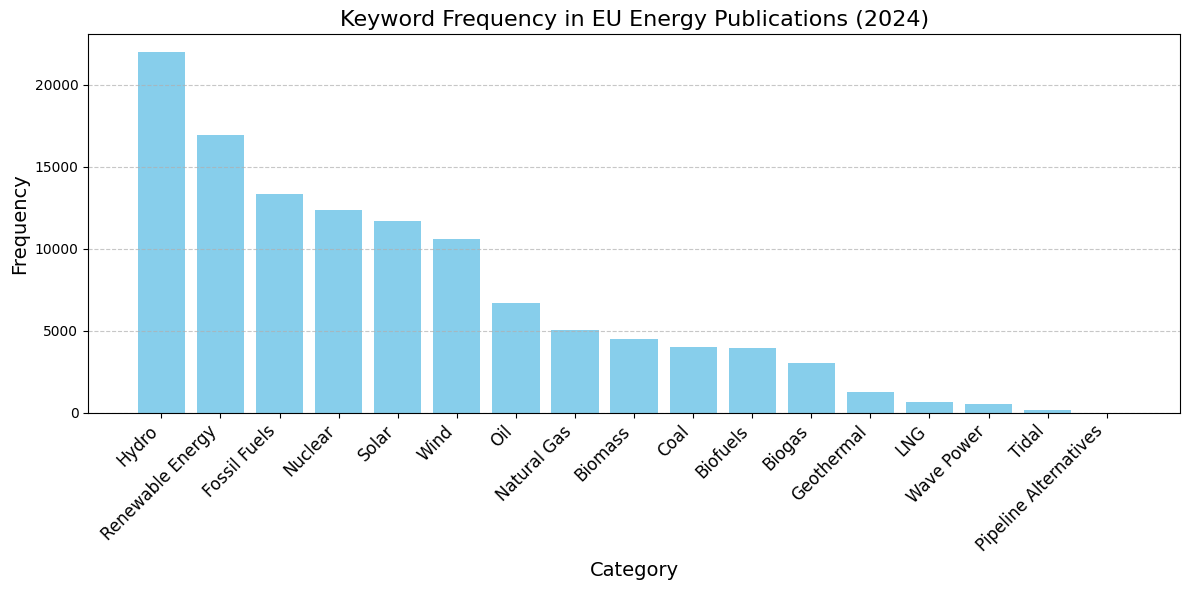

In [53]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2024["Category"], df_2024["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2024)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [15]:
# Define the folder containing the EU energy publications in 2019
EU_Energy_publications_2019 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2019'

In [ ]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2019):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2019, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2019 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2019)

Processing: a%20bright%20future-QH0319395ENN.pdf
Processing: operating%20experience%20with%20digital%20i%26c%20systems%20at%20nuclear-KJNA29618ENN.pdf
Processing: study%20on%20consumer%20understanding%20of%20draft%20energy%20labels-KH0419169ENN.pdf
Processing: mapping%20threats%20to%20peace%20and%20democracy%20worldwide-QA0419443ENN.pdf
Processing: dg%20energy%20news%20december%202019-MJAF19012ENN.pdf
Processing: competitiveness%20of%20renewable%20heating%20and%20cooling%20industry-MJ0319525ENN.pdf
Processing: support%20to%20key%20activities%20of%20the%20european%20technology-KI0419135ENN.pdf
Processing: effect%20of%20high%20shares%20of%20renewables%20on%20power%20systems-MJ0319327ENN.pdf
Processing: position%20paper%20on%20water%20energy%20food%20and%20ecosystems-KJNA29509ENN.pdf
Processing: inea-QJAB19014ENN.pdf
Processing: dg%20energy%20news%20march%202019-MJAF19003ENN.pdf
Processing: tabletop%20exercise-KJNA29872ENN.pdf
Processing: do%20current%20regulatory%20frameworks%20in%20the%

In [ ]:
# Sort the DataFrame by frequency in descending order
df_2019 = df_2019.sort_values(by="Frequency", ascending=False)

In [ ]:
# Define a styled DataFrame with custom styles
styled_df_2019 = df_2019.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2019)

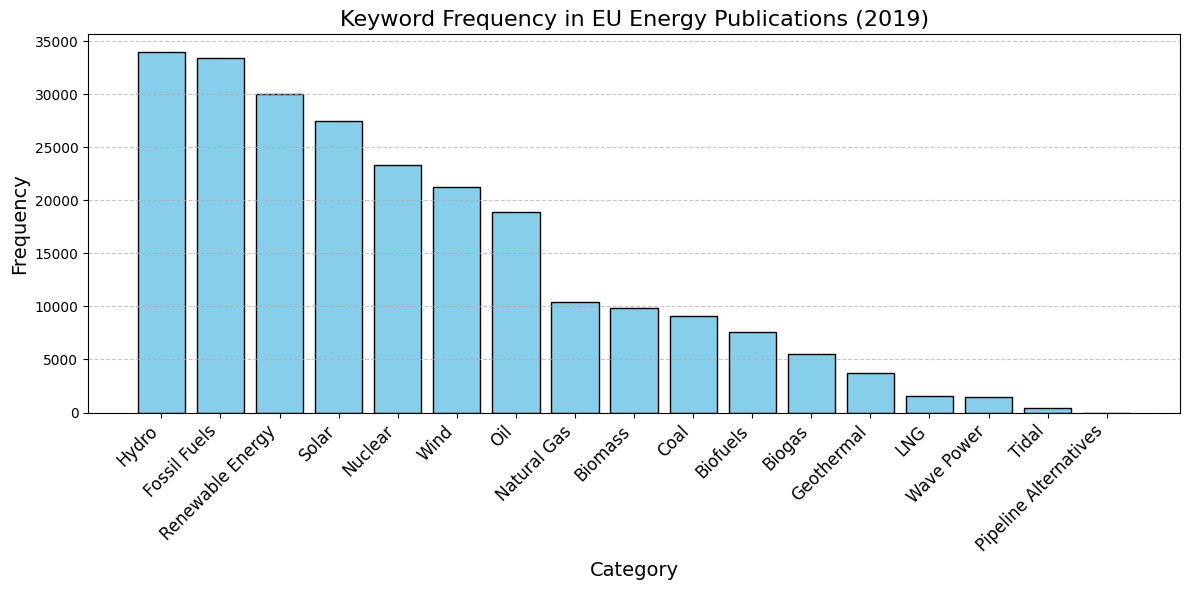

In [ ]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2019["Category"], df_2019["Frequency"], color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2019)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [1]:
# Define the folder containing the EU energy publications in 2020
EU_Energy_publications_2020 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2020'

In [3]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2020):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2020, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2020 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2020)

NameError: name 'os' is not defined

In [ ]:
# Sort the DataFrame by frequency in descending order
df_2020 = df_2020.sort_values(by="Frequency", ascending=False)

In [ ]:
# Define a styled DataFrame with custom styles
styled_df_2020 = df_2020.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2020)

,Category,Frequency
16,Fossil Fuels,61551
7,Hydro,51986
1,Renewable Energy,45237
10,Solar,44121
11,Wind,41230
4,Oil,34946
6,Nuclear,34241
5,Natural Gas,19113
3,Coal,17027
14,Biomass,14395


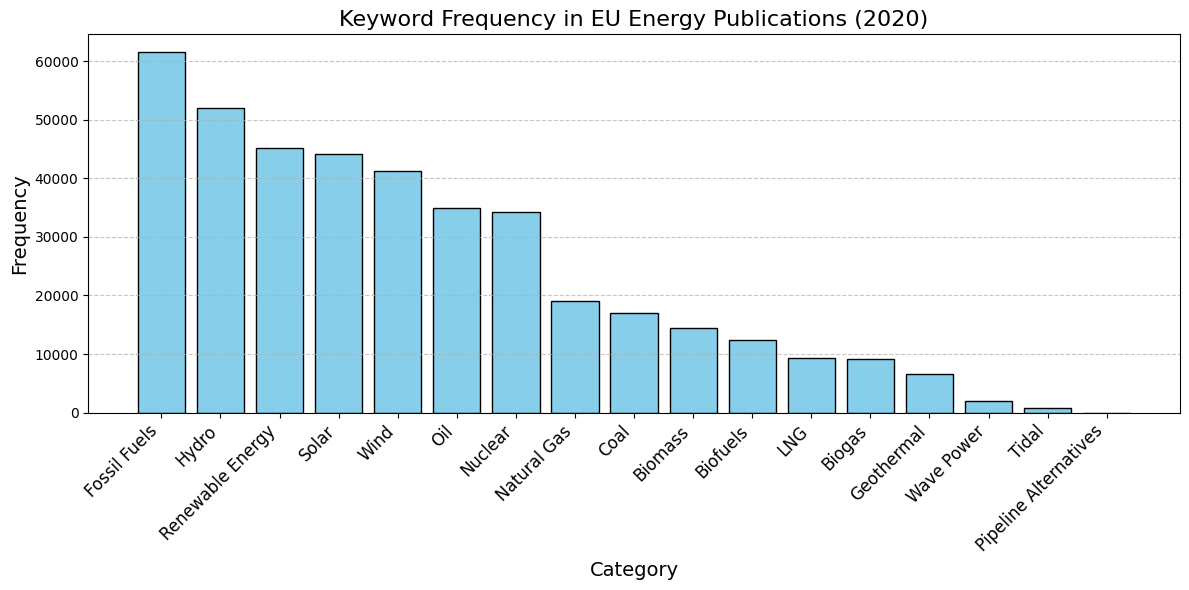

In [ ]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2020["Category"], df_2020["Frequency"], color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2020)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
# Define the folder containing the EU energy publications in 2021
EU_Energy_publications_2021 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2021'

In [ ]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2021):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2021, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2021 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2021)

Processing: cinea%20european%20climate%20infrastructure%20and%20environment-EF0221483ENN.pdf
Processing: solar%20photovoltaic%20modules%20inverters%20and%20systems-KJNA30474ENN.pdf
Processing: 5g%20supply%20market%20trends-KK0521236ENN.pdf
Processing: geolocation%20of%20hydrogen%20production%20in%20the%20eu-MJ0320495ENN.pdf
Processing: implementation%20of%20the%20network%20code%20on%20requirements-MJ0921258ENN.pdf
Processing: dg%20energy%20news%20january%202021-MJAF21001ENN.pdf
Processing: renewable%20hydrogen%20and%20the%20%E2%80%9Cadditionality%E2%80%9D%20requirement-QMAX21036ENN.pdf
Processing: green%20growth%20jobs%20and%20social%20impacts-KH0921053ENN.pdf
Processing: chip-scale%20atomic%20clocks-KJNA30790ENN-compressed.pdf
Processing: european%20barriers%20in%20retail%20energy%20markets-MJ0221195ENN.pdf
Processing: good%20practice%20guide%20for%20validation%20of%20a%20waste%20characterisation-KJNA30761ENN.pdf
Processing: policy%20and%20regulatory%20challenges%20for%20the%20deploym

KeyboardInterrupt: 

In [ ]:
# Sort the DataFrame by frequency in descending order
df_2021 = df_2021.sort_values(by="Frequency", ascending=False)

In [ ]:
# Define a styled DataFrame with custom styles
styled_df_2021 = df_2021.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2021)

In [ ]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2021["Category"], df_2021["Frequency"], color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2024)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
# Define the folder containing the EU energy publications in 2022
EU_Energy_publications_2022 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2022'

In [ ]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2022):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2022, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2022 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2022)

In [ ]:
# Sort the DataFrame by frequency in descending order
df_2022 = df_2022.sort_values(by="Frequency", ascending=False)

In [ ]:
# Define a styled DataFrame with custom styles
styled_df_2022 = df_2022.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2022)

In [ ]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2022["Category"], df_2022["Frequency"], color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2022)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
# Define the folder containing the EU energy publications in 2023
EU_Energy_publications_2023 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2023'

In [ ]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2023):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2023, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2023 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2023)

In [ ]:
# Sort the DataFrame by frequency in descending order
df_2023 = df_2023.sort_values(by="Frequency", ascending=False)

In [ ]:
# Define a styled DataFrame with custom styles
styled_df_2023 = df_2023.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2023)

In [ ]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2023["Category"], df_2023["Frequency"], color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2023)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
# prompt: write a code to make a plot comparing the frequency of mentions of the categories in different years (compare in percentages from keywords in one year)

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_2019, df_2020, df_2021, df_2022, and df_2023 are already defined as in your original code.

# Function to calculate percentages
def calculate_percentages(df):
    total = df["Frequency"].sum()
    df["Percentage"] = (df["Frequency"] / total) * 100
    return df

# Calculate percentages for each year
df_2019 = calculate_percentages(df_2019)
df_2020 = calculate_percentages(df_2020)
df_2021 = calculate_percentages(df_2021)
df_2022 = calculate_percentages(df_2022)
df_2023 = calculate_percentages(df_2023)


# Combine DataFrames for plotting
years = [2019, 2020, 2021, 2022, 2023]
dfs = [df_2019, df_2020, df_2021, df_2022, df_2023]
category_order = df_2019["Category"] # Use categories from 2019 as a reference order


# Create the plot
plt.figure(figsize=(14, 8))

width = 0.15
x = range(len(category_order))

for i, year in enumerate(years):
    percentages = dfs[i].set_index("Category").reindex(category_order)["Percentage"].fillna(0)  # Handle missing categories
    plt.bar([val + i * width for val in x], percentages, width, label=year)

plt.xticks([val + 1.5*width for val in x], category_order, rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Percentage of Mentions")
plt.title("Category Mentions Percentage Over Time")
plt.legend()
plt.tight_layout()
plt.show()